# Hybrid Mode - Dataset Creation 
we want to use the following structure to train our model:

Input:
- idea_text: "AI-powered e-commerce platform..."
- static_features: [market_size, investment, competition, team_strength]
- historical_stock: [month_1, month_2, ..., month_36]

Target:
- stock_performance (next 12 months): [month_37, month_38, ..., month_48]

---


This should then produce the follwoing output with our model:

Input:
- idea_text: "AI-powered e-commerce platform..."

Optional Input:
- static_features: [market_size, investment, competition, team_strength]

Output:
- Predicted stock performance (next 12 months): [month_1, month_2, ..., month_12]


### Huggingface Dataset
We will use the shortbread/tickers dataset to get tickers of US companies

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from datasets import load_dataset

# Load the dataset
def get_tickers_dataset(file_path: str) -> (pd.DataFrame, dict):
    dataset = pd.read_csv(file_path)

    # Rename Symbol column to tickers
    dataset.rename(columns={'Symbol': 'tickers'}, inplace=True)

    # Transform IPO Year into Company Age
    current_year = datetime.now().year
    dataset['Company_Age'] = current_year - dataset['IPO Year'].fillna(current_year).astype(int)

    # Drop irrelevant columns
    dataset = dataset.drop(columns=['Name', 'Net Change', 'IPO Year'])

    # Clean monetary and percentage columns
    monetary_columns = ['Market Cap', 'Last Sale']
    percentage_columns = ['% Change']

    # Remove symbols and convert to numeric
    for col in monetary_columns:
        dataset[col] = dataset[col].replace(r'[\$,]', '', regex=True).astype(float)
    for col in percentage_columns:
        dataset[col] = dataset[col].replace(r'[\%]', '', regex=True).astype(float)

    # Handle missing values
    # Fill numeric columns with 0
    numeric_columns = ['Market Cap', 'Volume', '% Change', 'Last Sale']
    dataset[numeric_columns] = dataset[numeric_columns].fillna(0)

    # Fill categorical columns with "General" or "Unknown"
    categorical_columns = ['Country', 'Sector', 'Industry']
    dataset[categorical_columns] = dataset[categorical_columns].fillna("General")

    # Apply Label Encoding to categorical columns
    encoders = {}
    for col in categorical_columns:
        encoder = LabelEncoder()
        dataset[col] = encoder.fit_transform(dataset[col])
        encoders[col] = encoder  # Save the encoder for reuse

    # Set tickers as the index
    dataset.set_index('tickers', inplace=True)
    return dataset, encoders


def extend_dataset(initial_dataset: pd.DataFrame, encoders: dict) -> pd.DataFrame:
    # Load the new dataset
    new_dataset = load_dataset("shortbread/tickers", split="train")

    # Convert the new dataset to a pandas DataFrame
    new_df = pd.DataFrame(new_dataset)

    # Select only the required column and rename 'symbol' to 'tickers'
    updated_dataset = new_df[['symbol']].rename(columns={'symbol': 'tickers'})

    # Ensure 'tickers' is accessible in initial_dataset
    if 'tickers' not in initial_dataset.columns:
        # If tickers is the index, reset it
        if initial_dataset.index.name == 'tickers':
            initial_dataset = initial_dataset.reset_index()
        else:
            raise KeyError("'tickers' column is missing in the initial dataset.")

    # Check for tickers in the updated_dataset that are not in the initial_dataset
    initial_tickers = set(initial_dataset['tickers'])
    updated_tickers = set(updated_dataset['tickers'])

    # Get the tickers that are unique to the updated dataset
    unique_tickers = updated_tickers - initial_tickers
    print(f"Number of tickers unique to the updated dataset: {len(unique_tickers)}")

    # Filter the updated dataset to include only unique tickers
    unique_tickers_df = updated_dataset[updated_dataset['tickers'].isin(unique_tickers)]

    # Prepare to enrich the unique tickers with additional data
    enriched_data = []
    required_columns = [
        "Last Sale", "Market Cap", "% Change", "Volume", "Country", "Sector", "Industry"
    ]

    # Process each unique ticker
    for ticker in unique_tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info  # Fetch data from yfinance

            # Enrichment logic
            previous_close = info.get("regularMarketPreviousClose", None)
            current_open = info.get("regularMarketOpen", None)

            enriched_row = {
                "tickers": ticker,
                # Use totalAssets as a proxy for Market Cap if marketCap is not available
                "Market Cap": info.get("marketCap", None) or info.get("totalAssets", None),
                # Use regularMarketPreviousClose or regularMarketDayHigh for Last Sale
                "Last Sale": info.get("regularMarketPreviousClose", None) or info.get("regularMarketDayHigh", None),
                # Calculate % Change from regularMarketOpen and regularMarketPreviousClose if not directly available
                "% Change": (
                                ((current_open - previous_close) / previous_close) * 100
                                if previous_close and current_open else None
                            ) or info.get("regularMarketChangePercent", None),
                "Volume": info.get("regularMarketVolume", None),
                "Country": info.get("country", "General"),
                "Sector": info.get("sector", "General"),
                "Industry": info.get("industry", "General"),
            }

            enriched_data.append(enriched_row)

        except Exception as e:
            print(f"Failed to fetch data for ticker {ticker}: {e}")

    # Convert enriched data to a DataFrame
    enriched_df = pd.DataFrame(enriched_data)

    # Apply the same LabelEncoder to categorical columns in the enriched data
    categorical_columns = ['Country', 'Sector', 'Industry']
    for col in categorical_columns:
        if col in enriched_df.columns:
            enriched_df[col] = enriched_df[col].map(
                lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1
            )

    # Merge the initial dataset with the enriched dataset
    extended_dataset = pd.concat([initial_dataset, enriched_df], ignore_index=True)

    # Set tickers as the index
    extended_dataset.set_index('tickers', inplace=True)

    return extended_dataset


### Fetching additional data
We use the dataset from Hugginface as startingpoint and will now provide methods to fetch additional data

In [11]:
import pandas as pd
import yfinance as yf
import os
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

def fetch_all_data_for_ticker(ticker, months=72):
    """
    Fetch all required information for a given ticker in a single API call.
    """
    try:
        stock = yf.Ticker(ticker)

        # Fetch historical stock data
        hist = stock.history(period="max", interval="1mo")

        if hist.empty:
            # print(f"$ {ticker}: No price data found (possibly delisted or insufficient history).")
            return None

        # Adjust the range to available data if it's less than the requested months
        padding = max(0, months - len(hist))
        months = min(months, len(hist))

        # Extract the last `months` of closing prices
        monthly_close = [None] * padding + hist["Close"][-months:].tolist()

        # Fetch business summary, investment, team strength, and other metrics
        info = stock.info  # Single call to retrieve all general info

        description = info.get("longBusinessSummary", None)
        if description is None:
            return None

        investment = stock.balance_sheet.loc["Total Assets"].iloc[0] if not stock.balance_sheet.empty else None
        team_strength = info.get("fullTimeEmployees", None)

        # Extract additional metrics
        ebit = info.get("ebitda", None)  # Approximation if EBITDA is provided
        revenue = info.get("totalRevenue", None)
        revenue_growth = info.get("revenueGrowth", None)
        net_income = info.get("netIncomeToCommon", None)
        operating_margins = info.get("operatingMargins", None)
        ebitda_margins = info.get("ebitdaMargins", None)
        free_cashflow = info.get("freeCashflow", None)
        total_debt = info.get("totalDebt", None)
        current_ratio = info.get("currentRatio", None)
        quick_ratio = info.get("quickRatio", None)

        # Valuation and market metrics
        enterprise_value = info.get("enterpriseValue", None)
        price_to_sales = info.get("priceToSalesTrailing12Months", None)
        trailing_pe = info.get("trailingPE", None)
        forward_pe = info.get("forwardPE", None)
        profit_margins = info.get("profitMargins", None)
        return_on_assets = info.get("returnOnAssets", None)

        # Stock price and volatility
        fifty_two_week_high = info.get("fiftyTwoWeekHigh", None)
        fifty_two_week_low = info.get("fiftyTwoWeekLow", None)
        beta = info.get("beta", None)

        # Analyst sentiment
        recommendation_mean = info.get("recommendationMean", None)
        recommendation_key = info.get("recommendationKey", None)
        target_high_price = info.get("targetHighPrice", None)
        target_low_price = info.get("targetLowPrice", None)
        target_mean_price = info.get("targetMeanPrice", None)

        # Return data as a dictionary
        return {
            "tickers": ticker,
            "business_description": description,
            "investment": investment,
            "team_strength": team_strength,
            "ebit": ebit,
            "revenue": revenue,
            "revenue_growth": revenue_growth,
            "net_income": net_income,
            "operating_margins": operating_margins,
            "ebitda_margins": ebitda_margins,
            "free_cashflow": free_cashflow,
            "total_debt": total_debt,
            "current_ratio": current_ratio,
            "quick_ratio": quick_ratio,
            "enterprise_value": enterprise_value,
            "price_to_sales": price_to_sales,
            "trailing_pe": trailing_pe,
            "forward_pe": forward_pe,
            "profit_margins": profit_margins,
            "return_on_assets": return_on_assets,
            "fifty_two_week_high": fifty_two_week_high,
            "fifty_two_week_low": fifty_two_week_low,
            "beta": beta,
            "recommendation_mean": recommendation_mean,
            "recommendation_key": recommendation_key,
            "target_high_price": target_high_price,
            "target_low_price": target_low_price,
            "target_mean_price": target_mean_price,
            **{f"month_{i+1}_performance": sp for i, sp in enumerate(monthly_close or [None] * months)}
        }

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


def create_real_dataset(tickers, months):
    """
    Create dataset using a single API call per ticker while retaining existing data.
    """
    # List to collect new fetched data
    new_data = []

    for _, entry in tickers.iterrows():
        ticker = entry['tickers']  # Access 'tickers' column

        # Fetch all data for the ticker
        ticker_data = fetch_all_data_for_ticker(ticker, months)

        if ticker_data is None:
            continue

        # Append fetched data to the new_data list
        new_data.append(ticker_data)

    # Convert new_data to a DataFrame
    new_data_df = pd.DataFrame(new_data)

    if new_data_df.empty:
        return pd.DataFrame()

    # Filter the original dataset to only include tickers with fetched data
    valid_tickers = new_data_df['tickers']
    filtered_tickers = tickers[tickers['tickers'].isin(valid_tickers)]

    # Merge the original dataset with the new data
    merged_dataset = filtered_tickers.merge(new_data_df, on='tickers', how='inner')

    return merged_dataset


def process_tickers_in_batches(tickers, batch_size=50, output_file="Data/real_company_stock_dataset.csv", months=72):
    # Ensure 'tickers' column exists
    if tickers.index.name == 'tickers':
        tickers.reset_index(inplace=True)

    # Process tickers in batches
    for i in range(0, len(tickers), batch_size):
        batch = tickers.iloc[i:i + batch_size].copy()  # Use .copy() to avoid SettingWithCopyWarning
        print(f"Processing batch {i // batch_size + 1} of {len(tickers) // batch_size + 1}...")

        # Process the batch using the existing method
        batch_data = create_real_dataset(batch, months=months)

        # Check if batch_data is empty
        if batch_data.empty:
            # Log all tickers from this batch as skipped
            batch['reason'] = 'Missing Data'  # Safe because of .copy()
            batch.to_csv("skipped_tickers.csv", mode='a', header=False, index=False)
            continue

        # Log skipped tickers
        skipped_tickers = batch[~batch['tickers'].isin(batch_data['tickers'])].copy()  # Use .copy()
        if not skipped_tickers.empty:
            skipped_tickers['reason'] = 'Missing Data'  # Safe because of .copy()
            skipped_tickers.to_csv("skipped_tickers.csv", mode='a', header=False, index=False)

        # Save the batch to the output file
        if not batch_data.empty:
            if not os.path.exists(output_file):
                batch_data.to_csv(output_file, index=False)
            else:
                batch_data.to_csv(output_file, mode='a', header=False, index=False)

        print(f"Batch {i // batch_size + 1} processed and saved. Skipped Tickers: {len(skipped_tickers)}")

        # Add a delay between batches to respect API rate limits
        time.sleep(10)  # Adjust as needed


### Normalization Function

In [12]:
def normalize_full_dataset(input_file="Data/real_company_stock_dataset.csv",
                           output_file="Data/normalized_real_company_stock_dataset.csv",
                           scalar_directory="Data/Scalar/"):
    try:
        dataset = pd.read_csv(input_file)

        # Identify static and historical columns
        excluded_columns = ['tickers', 'business_description']
        static_columns = [col for col in dataset.columns if col not in excluded_columns and not col.startswith('month_')]
        historical_columns = [col for col in dataset.columns if col.startswith('month_')]

        # Create a dictionary to store scalers for each static column
        static_scalers = {}

        # Ensure the scalar directory exists
        os.makedirs(scalar_directory, exist_ok=True)

        # Normalize static columns
        for col in static_columns:
            try:
                scaler = StandardScaler()  # or MinMaxScaler()
                dataset[col] = scaler.fit_transform(dataset[[col]])
                static_scalers[col] = scaler

                # Save the scaler for the column
                scaler_path = f"{scalar_directory}/{col}_scaler.pkl"
                joblib.dump(scaler, scaler_path)
            except Exception as e:
                print(f"Error normalizing column '{col}': {e}")
                print(f"First few problematic entries in column '{col}':")
                print(dataset[[col]].head())  # Display the first few entries in the problematic column
                return  # Abort the normalization process

        # Normalize historical columns using a single scaler
        try:
            historical_scaler = MinMaxScaler(feature_range=(0, 1))
            dataset[historical_columns] = historical_scaler.fit_transform(dataset[historical_columns])

            # Save the historical scaler
            historical_scaler_path = f"{scalar_directory}/historical_scaler.pkl"
            joblib.dump(historical_scaler, historical_scaler_path)
        except Exception as e:
            print(f"Error normalizing historical columns: {e}")
            print(f"First few problematic entries in historical columns:")
            print(dataset[historical_columns].head())  # Display the first few rows of the problematic columns
            return  # Abort the normalization process

        # Save the normalized dataset
        dataset.to_csv(output_file, index=False)

        print("Normalization complete. Static scalers saved for each column. Historical scaler updated.")
    except Exception as e:
        print(f"An error occurred during normalization: {e}")


def create_historical_scaler_for_n_months(
        input_file="Data/normalized_real_company_stock_dataset.csv",
        scaler_folder="Data/Scaler",
        last_n_months=12,
        denormalize_first=False
):
    # Load dataset
    dataset = pd.read_csv(input_file)

    # Identify month columns
    month_columns = [col for col in dataset.columns if col.startswith("month")]
    if not month_columns:
        raise ValueError("No columns starting with 'month' found in the dataset.")

    # Initialize scaler
    historical_scaler = MinMaxScaler(feature_range=(0, 1))
    scaler_path = os.path.join(scaler_folder, f"historical_scaler_{last_n_months}.pkl")

    # Denormalize if required
    if denormalize_first:
        original_scaler_path = os.path.join(scaler_folder, "historical_scaler.pkl")
        if os.path.exists(original_scaler_path):
            with open(original_scaler_path, "rb") as f:
                original_scaler = joblib.load(f)

            # Apply inverse transformation only to month columns
            dataset[month_columns] = pd.DataFrame(
                original_scaler.inverse_transform(dataset[month_columns]),
                columns=month_columns
            )
        else:
            print(f"Scaler file not found at {original_scaler_path}. Proceeding with normalized data.")
            raise FileNotFoundError("Could not find scaler at {original_scaler_path}")

    # Fit the scaler on the last n months
    last_n_months_data = dataset[month_columns].iloc[:, -last_n_months:]
    historical_scaler.fit(last_n_months_data)

    # Save the scaler
    joblib.dump(historical_scaler, scaler_path)
    print(f"Scaler for the last {last_n_months} months saved at: {scaler_path}")

    return historical_scaler



### Remove Null Values
Just to make sure that there are no null values, we go through the dataset and replace them with -1.


In [13]:
def remove_null_values(path):
    try:
        # Load the dataset
        created_dataset = pd.read_csv(path)

        # Replace all null values with 0
        created_dataset = created_dataset.fillna(0)

        # Save the updated dataset back to the same file
        created_dataset.to_csv(path, index=False)

        print(f"Null values in {path} replaced with 0.")
    except Exception as e:
        print(f"An error occurred while processing {path}: {e}")


# Call method
# remove_null_values(NORMALIZED_OUTPUT_FILE)


### Fixture Method
As I made a small mistake for the base dataset here is a method to replace just that part

In [14]:
def fix_encoded_columns(base_file: str, enriched_file: str, output_file: str):
    """
    Fix encoding inconsistencies in the enriched dataset by replacing problematic columns.
    """
    # Step 1: Load the base dataset
    base_dataset = pd.read_csv(base_file, index_col='tickers')

    # Step 2: Load the already enriched dataset
    enriched_dataset = pd.read_csv(enriched_file)

    # Ensure 'tickers' is present
    if 'tickers' not in enriched_dataset.columns:
        # If tickers is the index, reset it
        if enriched_dataset.index.name == 'tickers':
            enriched_dataset.reset_index(inplace=True)
        else:
            raise KeyError("'tickers' column is missing in the enriched dataset.")

    # Step 3: Set 'tickers' as the index for alignment
    enriched_dataset.set_index('tickers', inplace=True)

    # Filter the base dataset to only include tickers in the enriched dataset
    overlapping_tickers = base_dataset.loc[base_dataset.index.intersection(enriched_dataset.index)]

    # Step 4: Replace inconsistent columns with properly encoded ones
    columns_to_fix = ['Country', 'Sector', 'Industry']
    enriched_dataset.update(overlapping_tickers[columns_to_fix])

    # Step 5: Save the updated enriched dataset
    enriched_dataset.reset_index(inplace=True)
    enriched_dataset.to_csv(output_file, index=False)

    print(f"Encoded columns fixed. Updated dataset saved to {output_file}")


### Label Encoder
This method can be used to later on encode additional columns (Used for recommendation_key as of right now)


In [15]:

def encode_columns(file_path: str, columns_to_encode: list, output_file: str = None) -> None:
    """
    Encodes specified columns in a dataset using LabelEncoder.

    Args:
    - file_path (str): Path to the dataset file (CSV).
    - columns_to_encode (list): List of column names to encode.
    - output_file (str): Optional. Path to save the updated dataset. If None, the dataset won't be saved.

    Returns:
    - pd.DataFrame: The dataset with encoded columns.
    """
    # Load the dataset
    dataset = pd.read_csv(file_path)

    # Ensure the columns exist in the dataset
    missing_columns = [col for col in columns_to_encode if col not in dataset.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing in the dataset: {', '.join(missing_columns)}")

    # Apply LabelEncoder to the specified columns
    label_encoders = {}  # To store encoders for each column
    for col in columns_to_encode:
        encoder = LabelEncoder()
        dataset[col] = encoder.fit_transform(dataset[col].fillna("Unknown"))
        label_encoders[col] = encoder  # Save the encoder in case we need to use it later

    # Save the updated dataset if output_file is provided
    if not output_file:
        print("Storing to input path")
        output_file = file_path

    dataset.to_csv(output_file, index=False)
    print(f"Updated dataset saved to {output_file}")


### Further Processing - Replacing inf by 99 Quartil
the 'price_to_sales' column might have the value 'inf' instead of a number which we need to replace

In [16]:
import numpy as np
def handle_inf_in_columns(dataset: pd.DataFrame, columns: list, cap_percentile: float = 0.99) -> pd.DataFrame:
    """
    Handle infinite values in specified columns of the dataset.

    Parameters:
    - dataset (pd.DataFrame): The dataset containing the columns to process.
    - columns (list): List of column names to process.
    - cap_percentile (float): The percentile to cap each column at (default is 99th percentile).

    Returns:
    - pd.DataFrame: The updated dataset with infinite values replaced.
    """
    for col in columns:
        if col not in dataset.columns:
            raise ValueError(f"'{col}' column not found in the dataset.")

        # Replace inf and -inf with NaN
        dataset[col] = dataset[col].replace([np.inf, -np.inf], np.nan)

        # Compute the 99th percentile cap value
        upper_limit = dataset[col].quantile(cap_percentile)

        # Replace NaN values (previously inf) with the median
        median_value = dataset[col].median()

        print(f"Handling '{col}': Capping at {upper_limit}, replacing NaN with median {median_value}")

        # Cap the values above the upper limit
        dataset[col] = np.where(
            dataset[col] > upper_limit,
            upper_limit,
            dataset[col]
        )

        # Fill remaining NaN values with the median
        dataset[col] = dataset[col].fillna(median_value)

    return dataset




### Dataset Visualization
THis method allows us to inspect our dataset

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_static_data(dataset: pd.DataFrame, scaler_folder: str = "Data/Scaler") -> None:
    """
    Visualize static features in the dataset by transforming them back to their original scale.

    Args:
        dataset (pd.DataFrame): The dataset containing normalized static data.
        scaler_folder (str): Path to the folder containing scalers for each static column.
    """
    # Identify static columns (exclude tickers, business_description, and columns starting with "month")
    static_columns = [
        col for col in dataset.columns
        if col not in ["tickers", "business_description"] and not col.startswith("month")
    ]

    # Revert normalization for each static column using its scaler
    original_data = pd.DataFrame()
    for col in static_columns:
        scaler_path = os.path.join(scaler_folder, f"{col}_scaler.pkl")
        if os.path.exists(scaler_path):
            try:
                scaler = joblib.load(scaler_path)  # Load the scaler using joblib
                original_data[col] = scaler.inverse_transform(dataset[[col]])
            except Exception as e:
                print(f"Error loading or using scaler for {col}: {e}. Skipping de-normalization.")
                original_data[col] = dataset[col]
        else:
            print(f"Scaler for {col} not found. Skipping de-normalization.")
            original_data[col] = dataset[col]

    # Create a summary of the de-normalized data
    print("Summary Statistics for De-Normalized Static Data:")
    print(original_data.describe())

    # Plot distributions for de-normalized static columns
    for col in original_data.columns:
        plt.figure(figsize=(8, 4))
        plt.hist(original_data[col].dropna(), bins=30, alpha=0.7, label=col)
        plt.title(f"Distribution of {col} (De-Normalized)")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()


def visualize_historical_data(dataset: pd.DataFrame, scaler_folder: str = "Data/Scaler") -> None:
    """
    Visualize historical performance data (columns starting with 'month')
    after applying the inverse transformation using a historical scaler.

    Args:
        dataset (pd.DataFrame): The dataset containing normalized historical data.
        scaler_path (str): Path to the scaler file for historical data.
    """
    # Identify historical performance columns
    month_columns = [col for col in dataset.columns if col.startswith("month")]

    # Select historical data
    historical_data = dataset[month_columns]

    # Apply the inverse transformation using the historical scaler

    scaler_path = os.path.join(scaler_folder, "historical_scaler.pkl")
    if os.path.exists(scaler_path):
        with open(scaler_path, "rb") as f:
            historical_scaler = joblib.load(f)
        historical_data_original = pd.DataFrame(
            historical_scaler.inverse_transform(historical_data),
            columns=month_columns,
        )
    else:
        print(f"Scaler file not found at {scaler_path}. Using normalized data.")
        historical_data_original = historical_data

    # Create a summary of the de-normalized data
    print("Summary Statistics for De-Normalized Historical Data:")
    print(historical_data_original.describe())

    # Plot line chart for historical performance for a subset of tickers
    plt.figure(figsize=(16, 8))
    subset = historical_data_original.iloc[:]  # Visualize data for the first 5 rows
    x_values = range(1, len(historical_data_original.columns) + 1)  # Generate numerical x-axis values
    for index, row in subset.iterrows():
        plt.plot(x_values, row)

    plt.title("Historical Performance (De-Normalized)")
    plt.xlabel("Months")
    plt.ylabel("Performance")
    plt.xticks(x_values)  # Set the x-axis ticks to match the numerical range
    plt.grid(True)
    plt.show()


# Main Function
Here we execute the above functions

Scaler for the last 12 months saved at: Data/Scaler/historical_scaler_12.pkl
Scaler for the last 24 months saved at: Data/Scaler/historical_scaler_24.pkl
Error loading or using scaler for Last Sale: Cannot set a frame with no defined index and a value that cannot be converted to a Series. Skipping de-normalization.
Summary Statistics for De-Normalized Static Data:
          Last Sale     % Change    Market Cap      Country        Volume  \
count  7.089000e+03  7089.000000  7.089000e+03  7089.000000  7.089000e+03   
mean  -1.252897e-17    -0.387853  1.236444e+10    44.541120  1.262462e+06   
std    1.000071e+00     5.598712  9.780552e+10    18.936332  8.248061e+06   
min   -2.975804e-01   -91.998232  5.722046e-06    -1.000000  2.328306e-10   
25%   -2.709196e-01    -1.429000  5.710959e+07    18.000000  3.032500e+04   
50%   -1.998433e-01    -0.172000  5.454748e+08    57.000000  1.427540e+05   
75%   -9.774575e-03     0.449000  3.681907e+09    57.000000  5.334780e+05   
max    5.369807e+

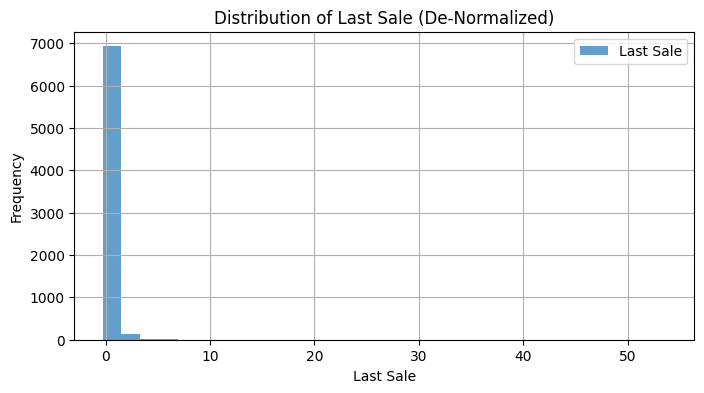

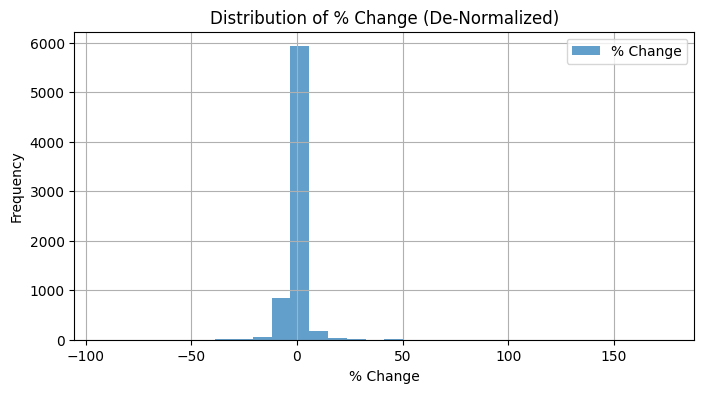

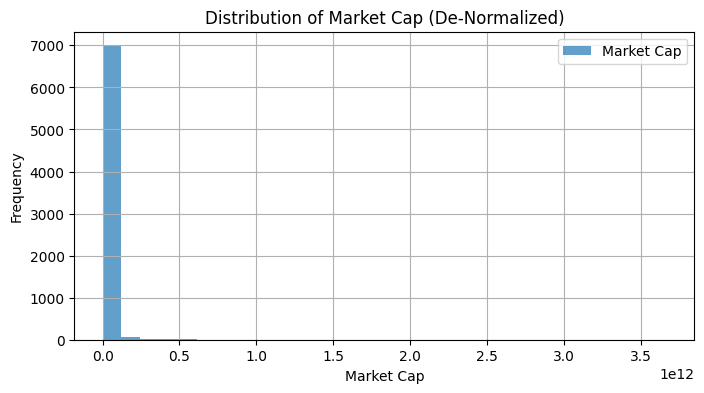

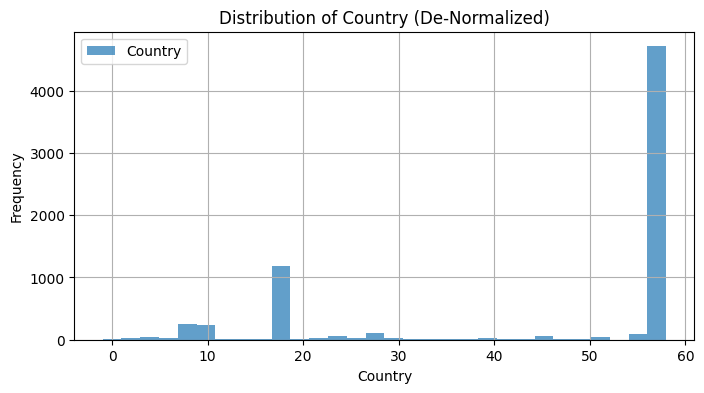

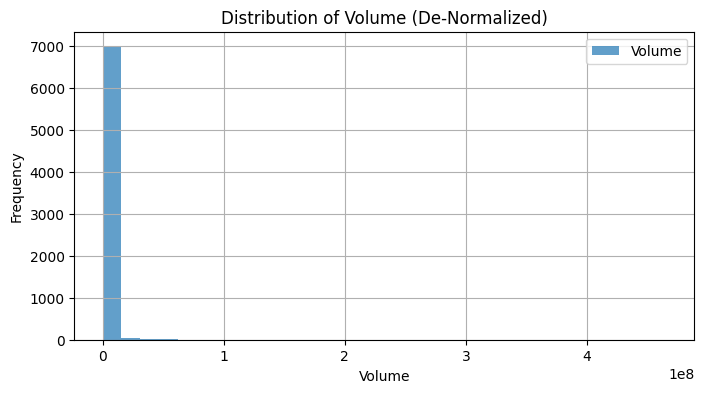

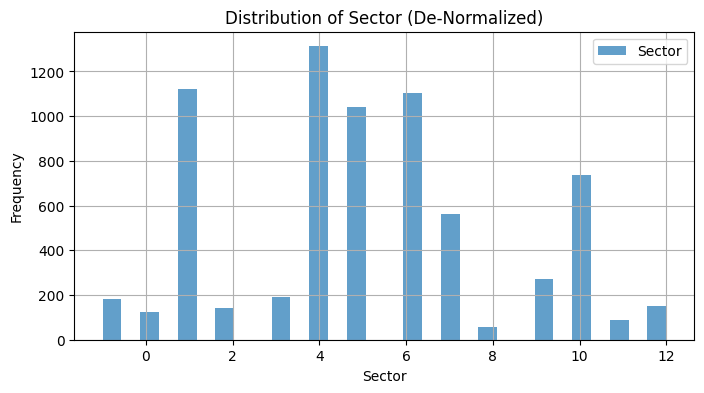

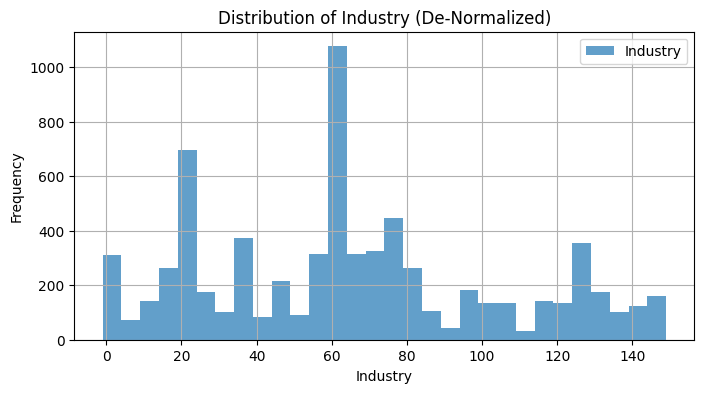

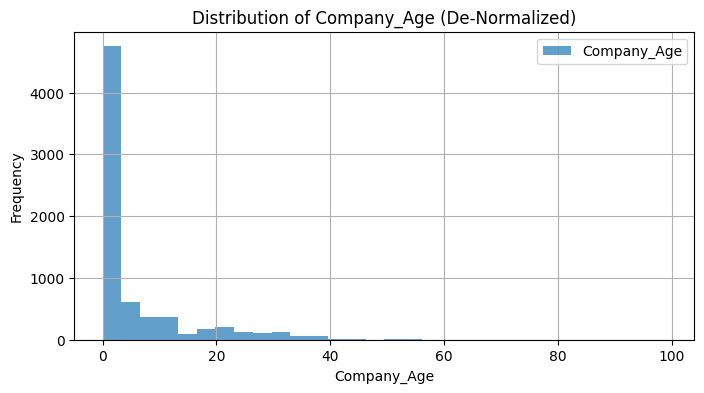

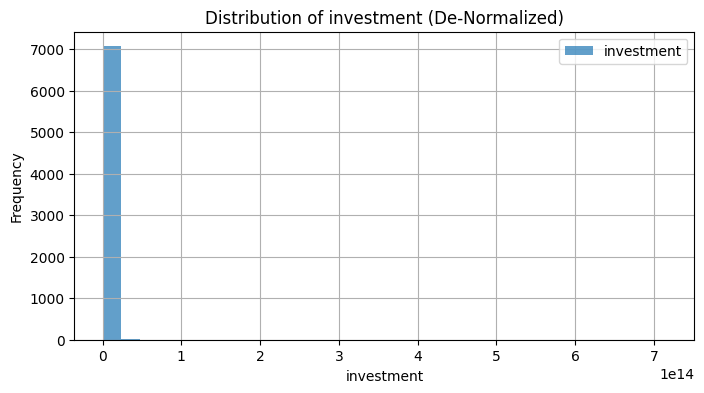

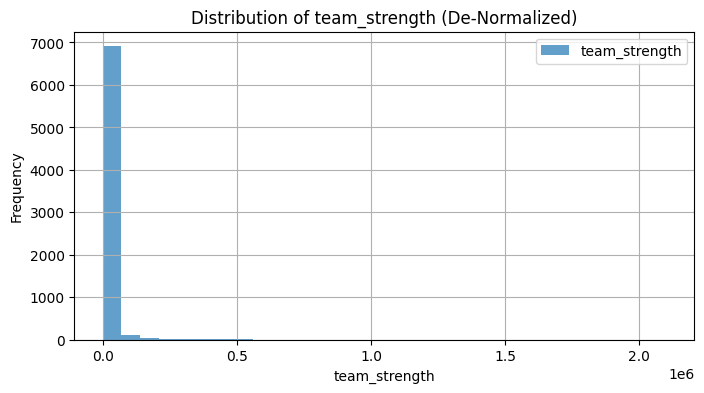

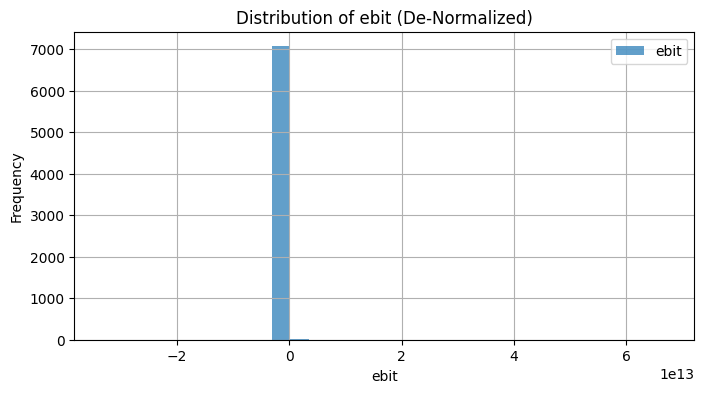

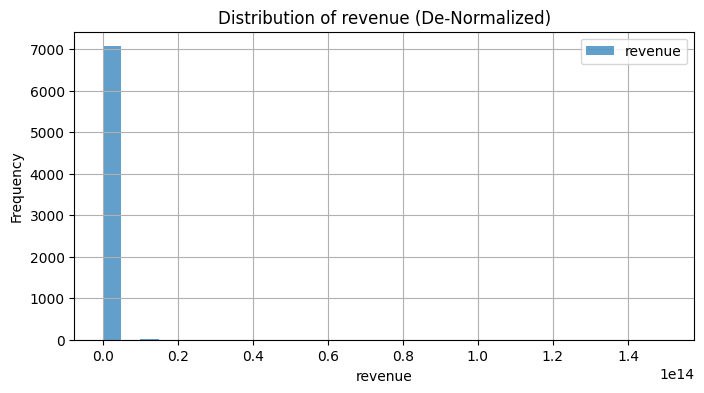

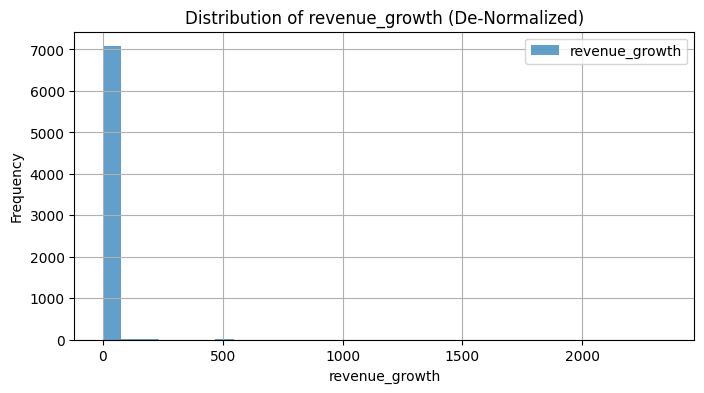

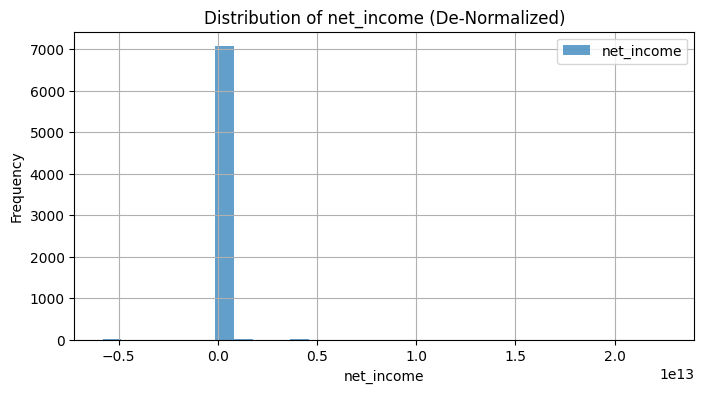

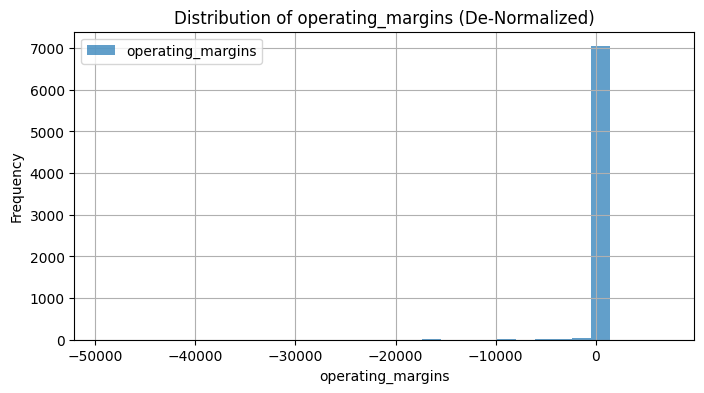

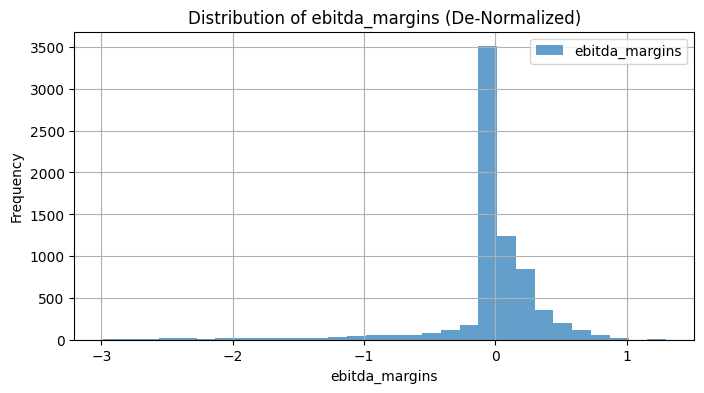

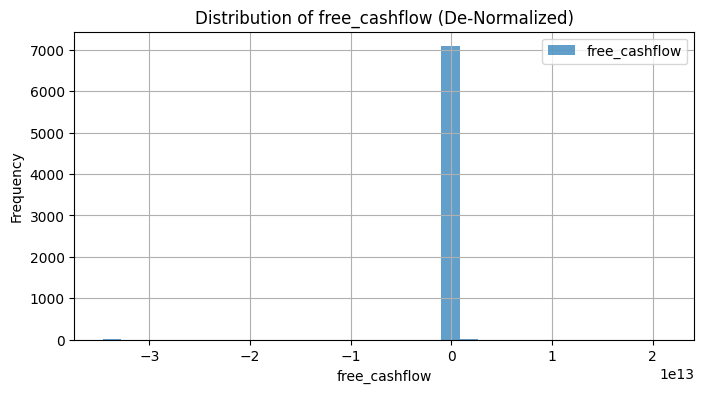

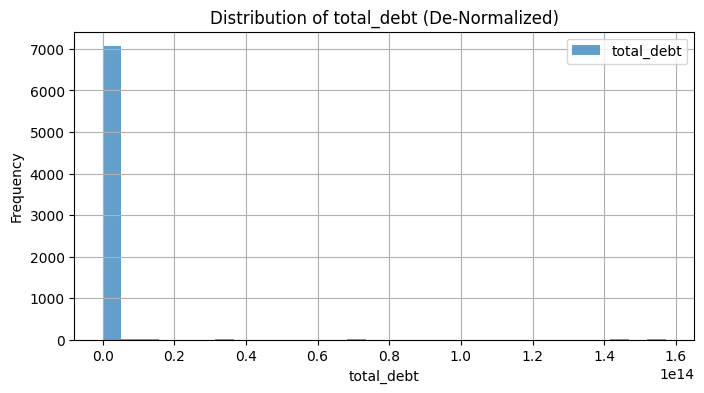

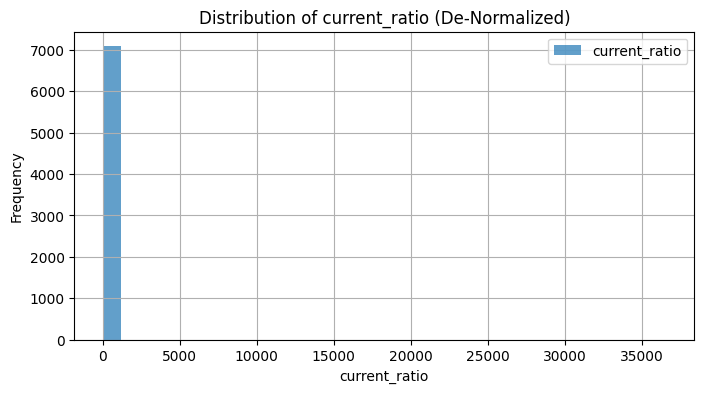

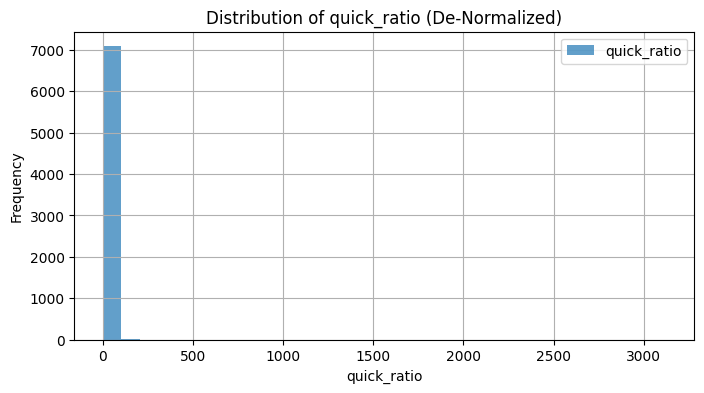

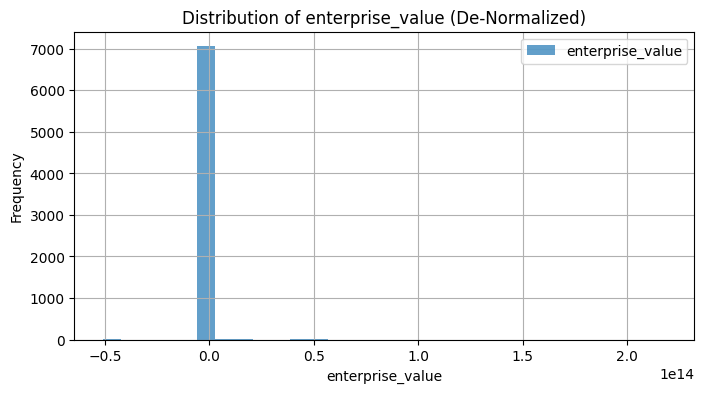

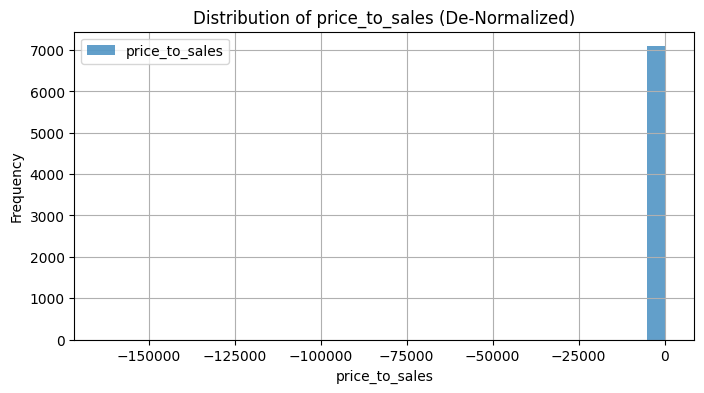

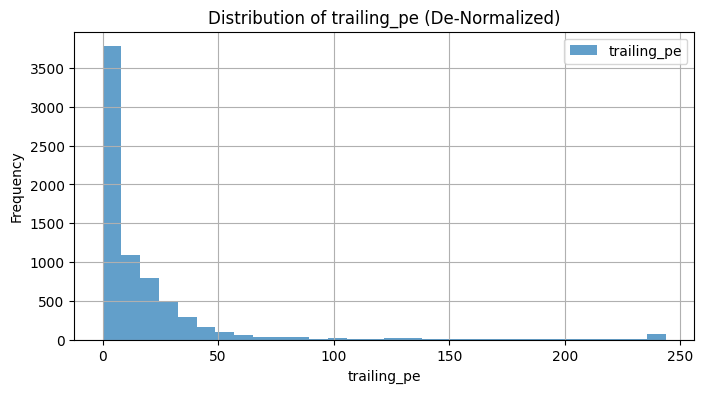

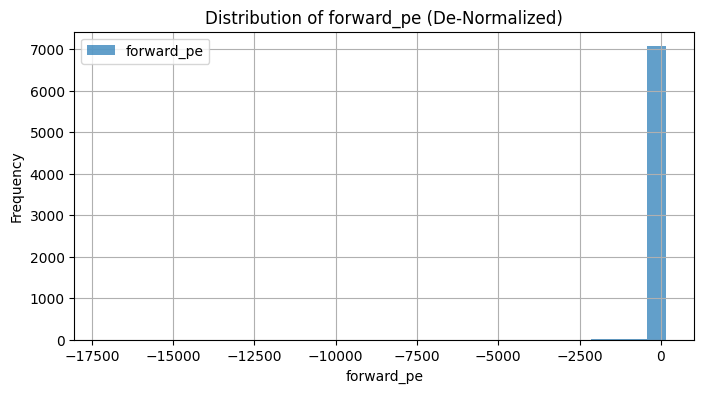

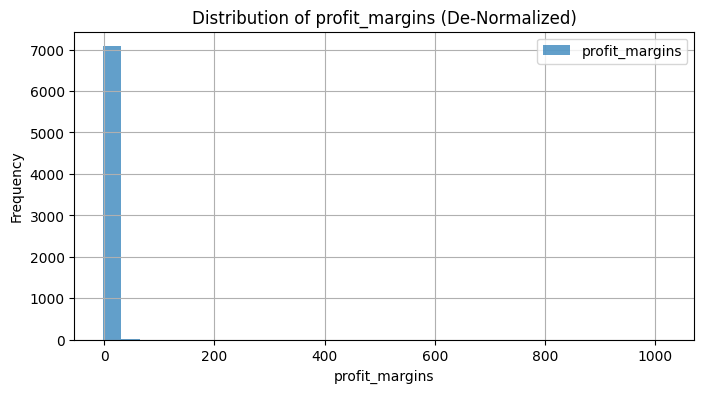

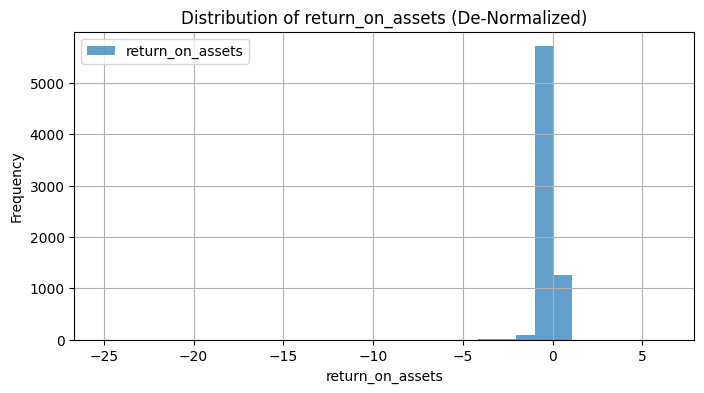

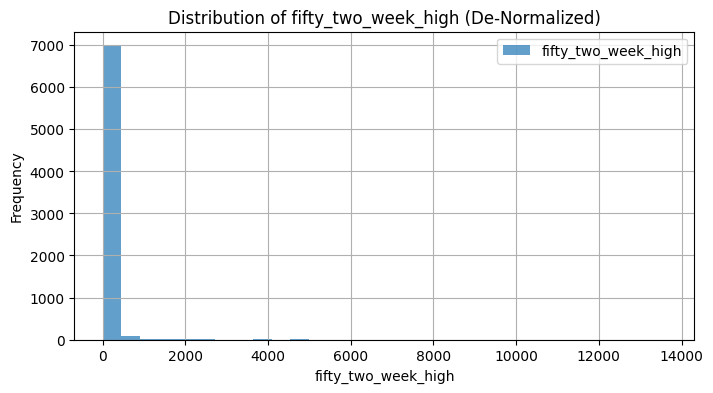

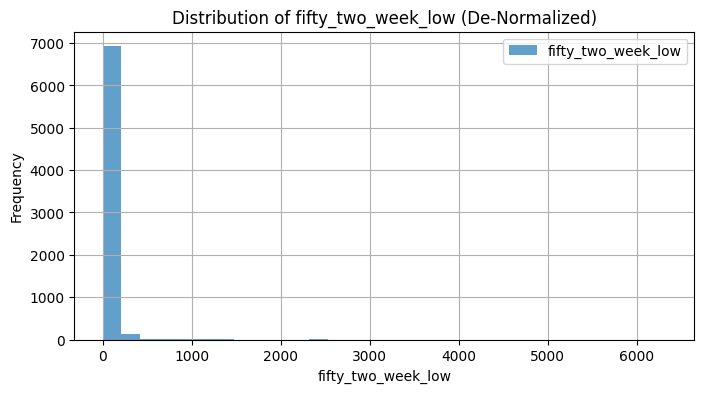

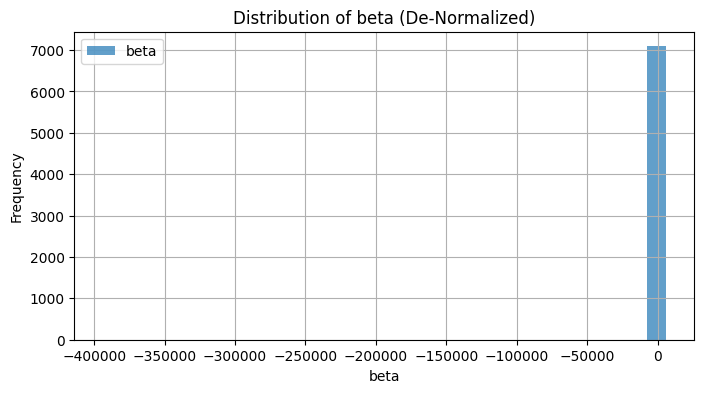

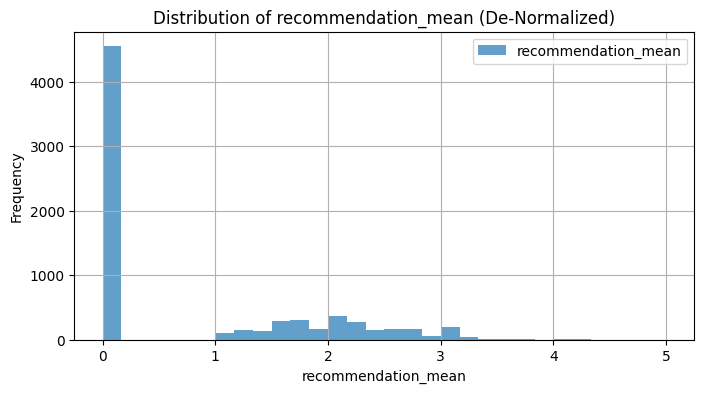

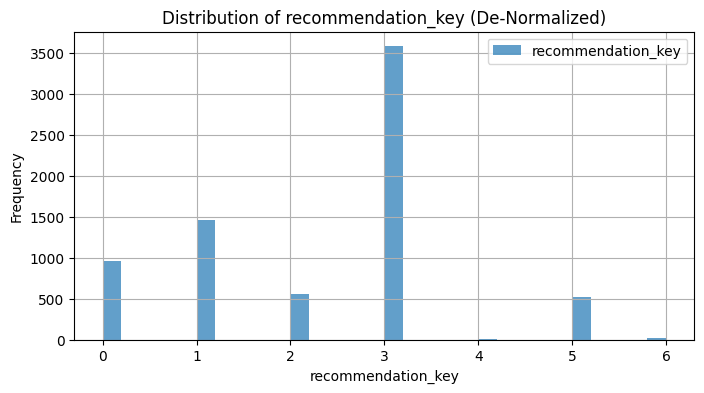

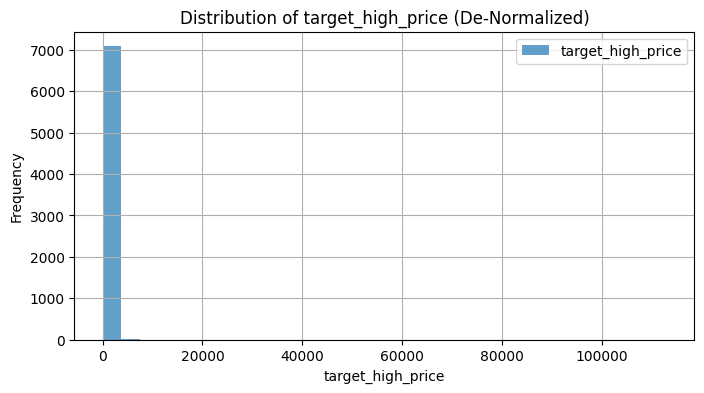

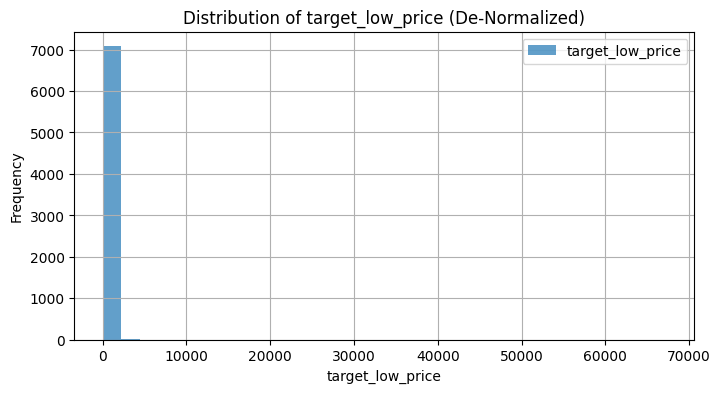

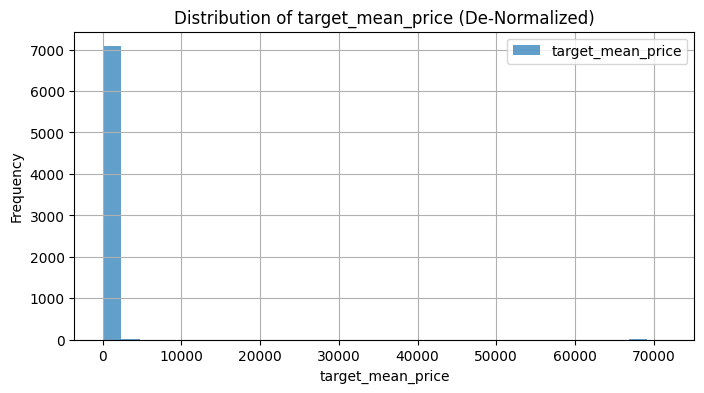

Summary Statistics for De-Normalized Historical Data:
       month_1_performance  month_2_performance  month_3_performance  \
count         7.089000e+03         7.089000e+03         7.089000e+03   
mean          5.253455e+03         4.931957e+03         3.183416e+03   
std           2.464726e+05         2.245739e+05         1.622668e+05   
min           0.000000e+00         0.000000e+00         0.000000e+00   
25%           0.000000e+00         0.000000e+00         0.000000e+00   
50%           1.317000e+01         1.373282e+01         1.352042e+01   
75%           3.792458e+01         3.928000e+01         3.890846e+01   
max           1.555980e+07         1.395000e+07         1.327500e+07   

       month_4_performance  month_5_performance  month_6_performance  \
count         7.089000e+03         7.089000e+03         7.089000e+03   
mean          2.779704e+03         2.017092e+03         2.352623e+03   
std           1.533052e+05         1.068941e+05         1.258347e+05   
min      

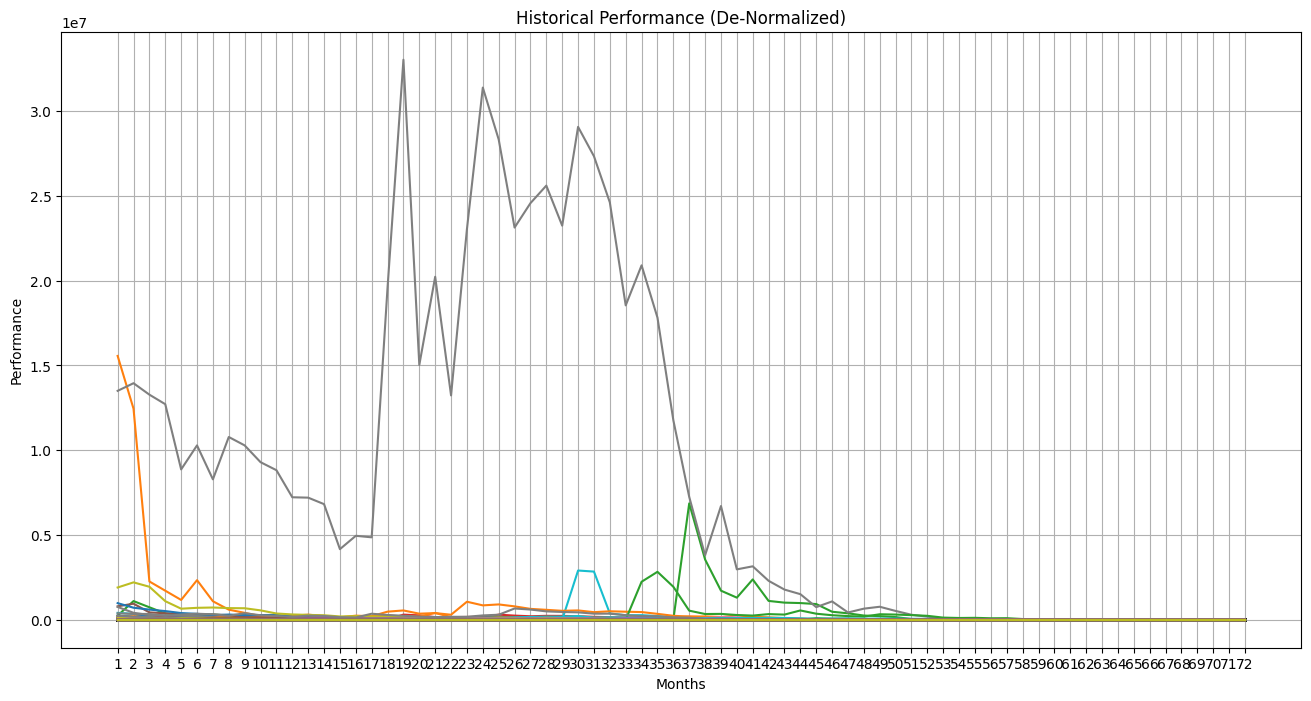

Dataset creation complete!


In [18]:

INPUT_FILE = "Ticker_Datasets/nasdaq_screener_1733257202149.csv"
OUTPUT_FILE = "Data/real_company_stock_dataset_large.csv"
NORMALIZED_OUTPUT_FILE = "Data/normalized_real_company_stock_dataset_large.csv"
INTERMEDIATE_OUTPUT_FILE = "Data/initial_dataset.csv"
SCALER_FOLDER = "Data/Scaler/"

REPLACE_INITIAL_DATASET = False
ENRICH = False
REMOVE_NULL = False
NORMALIZE = False
LABEL_ENCODE = False
REPLACE_INF = False
VISUALIZE = True
CREATE_N_SCALER = True

# Example usage
if __name__ == "__main__":

    # Simulated list of 10,000 tickers
    if REPLACE_INITIAL_DATASET:
        dataset, encoders = get_tickers_dataset(INPUT_FILE)
        extended_dataset = extend_dataset(dataset, encoders)
        print(dataset.head())

        # Fill null values
        dataset = dataset.fillna(0)

        # Store meanwhile
        extended_dataset.to_csv(INTERMEDIATE_OUTPUT_FILE, index=True)

    else:
        dataset = pd.read_csv(INTERMEDIATE_OUTPUT_FILE, index_col='tickers')

    if ENRICH:
        process_tickers_in_batches(dataset, output_file=OUTPUT_FILE, batch_size=100, months=72)

    if REPLACE_INITIAL_DATASET:
        fix_encoded_columns(INTERMEDIATE_OUTPUT_FILE, OUTPUT_FILE, OUTPUT_FILE)

    if REMOVE_NULL:
        # Normalize data
        remove_null_values(OUTPUT_FILE)

    if LABEL_ENCODE:
        encode_columns(OUTPUT_FILE, ['recommendation_key'], OUTPUT_FILE)

    if REPLACE_INF:
        adapted_dataset = pd.read_csv(OUTPUT_FILE)
        # Columns to handle for infinite values
        columns_to_handle = ['price_to_sales', 'trailing_pe', 'forward_pe']

        # Handle infinite values in the specified columns
        dataset = handle_inf_in_columns(adapted_dataset, columns_to_handle)

        adapted_dataset.to_csv(OUTPUT_FILE, index=False)


    if NORMALIZE:
        normalize_full_dataset(input_file=OUTPUT_FILE, output_file=NORMALIZED_OUTPUT_FILE, scalar_directory=SCALER_FOLDER)

    if CREATE_N_SCALER:
        n, m = 12, 24
        create_historical_scaler_for_n_months(last_n_months=n)
        create_historical_scaler_for_n_months(last_n_months=m)

    if VISUALIZE:
        visualize_static_data(dataset=pd.read_csv(NORMALIZED_OUTPUT_FILE))
        visualize_historical_data(dataset=pd.read_csv(NORMALIZED_OUTPUT_FILE))


    print("Dataset creation complete!")
